In [1]:
import os
import glob
import warnings
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# import shapely
import cartopy as ccrs
import cartopy.feature as cfeature

import geopandas as gpd

In [3]:
# configure data path

current_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(current_path, '..', 'data')

data_path = os.path.normpath(data_path)

In [2]:
# Read Greg's year event data

# event_100_year = pd.read_csv(os.path.join(data_path, "geoelectric_100year.csv"))
# event_100_year.head()

### Statistics of US Businesses (Employments and State GDPs)

In [5]:
# load GDP data
gdp_state = pd.read_csv(os.path.join(data_path, "SAGDP", "SAGDP1__ALL_AREAS_2017_2022.csv"))

# use gdp data (millions of chained 2017 dollars dollars)
state_2022 = gdp_state[gdp_state.Description == "Real GDP (millions of chained 2017 dollars) 1/"]
state_2022.loc[:, "STATE"]  = state_2022.GeoFIPS.apply(lambda fips: int(fips[2:4]))

# load the NAICS data
with open(os.path.join(data_path, "us_state_naics_detailedsizes_2020.txt"), encoding='utf-8', errors='ignore') as file:
    content = file.read()

content_io = StringIO(content)

us_states_details_naics = pd.read_csv(content_io)

# extract the total employments in each entersize per state
naics_total = us_states_details_naics[us_states_details_naics.NAICSDSCR == "Total"]
naics_total_empl = naics_total.drop_duplicates(subset=['STATE', 'ENTRSIZE', 'NAICSDSCR'])

states = naics_total_empl[naics_total_empl.STATE != 0]

state_empl = states.groupby(["STATE", "STATEDSCR"])["EMPL"].sum()
state_empl_reset = state_empl.reset_index()

# load the 2020 state population data
pop_data = pd.read_csv(os.path.join(data_path, "pop_2020_state.csv"))

# join the three datasets
state_gdp_empl_pop = state_empl_reset.merge(state_2022[["2022", "STATE"]], on="STATE").merge(pop_data, on="STATE")
state_gdp_empl_pop.rename(columns = {"2022": "2022REALGDP"}, inplace=True)
state_gdp_empl_pop.drop("STATE", axis=1, inplace=True)


# free some memory

del gdp_state
del state_empl 
del states 
del naics_total 
del us_states_details_naics 
del content_io
del state_empl_reset
del state_2022

state_gdp_empl_pop.head(5)

/tmp/ipykernel_113235/2617601370.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_2022.loc[:, "STATE"]  = state_2022.GeoFIPS.apply(lambda fips: int(fips[2:4]))


,STATEDSCR,EMPL,2022REALGDP,stab,POPULATION
0,Alabama,4644188,235807.3,AL,5024279
1,Alaska,728211,50315.1,AK,733391
2,Arizona,6771329,403474.2,AZ,7151502
3,Arkansas,2782909,137355.5,AR,3011524
4,California,41587052,3167460.8,CA,39538223


### US. Electricity Transmission Operators

In [6]:
# read the regional electricity transmission operators data

rto_data = gpd.read_file(os.path.join(data_path, "rto", "Regional Transmission Operators.shp"))
rto_data.head()

,id,REGIONS,geometry
0,1,CAISO,"POLYGON ((-124.00825 41.52646, -123.39450 41.4..."
1,2,NorthernGrid,"POLYGON ((-114.46552 34.77838, -114.66350 34.9..."
2,3,WestConnect,"POLYGON ((-104.05167 45.01356, -103.45772 45.0..."
3,4,SPP,"POLYGON ((-104.17046 31.92620, -104.17046 31.9..."
4,5,SPP,"POLYGON ((-111.87196 49.00682, -104.05167 49.0..."


### US Population at Census Block Levels

In [18]:
def format_tractce(tract):
    # add leading zeros if whole != 4 digits and trailing zero if decimal not 2 digits
    
    if type(tract) != str:
        whole, decimal = str(tract).split('.')
        # Add leading zeros to the whole number part if necessary to make it 4 digits
        whole = whole.zfill(4)
        if len(decimal) == 1:  # Check if decimal part is a single digit
            decimal += '0'  # Append a zero
        
        tract = f"{whole}.{decimal}"
    if type(tract) != str:
        print(tract)
    return tract.replace(".", "")

In [54]:
# load the data at block group levels

with open(os.path.join(data_path, "pop_2020_censu_block.csv"), encoding='utf-8', errors='ignore') as file:
    content = file.read()

content_io = StringIO(content)

pop_bg = pd.read_csv(content_io)
pop_bg.drop(0, inplace=True)

# non contig states
non_cont_fips_codes = ['02', '15', '72', '66', '60', '69', '78', '78']

pop_bg.rename(columns={"state":"STATEFP", "county":"COUNTYFP", "tract":"TRACTCE", "blockgroup":"BLKGRPCE", "pop20":"POP20BG", "afact":"AFACT"}, inplace=True)
pop_bg["TRACTCE"] = pop_bg.TRACTCE.apply(format_tractce)

# make thus columns string
cols_to_convert = ["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]
pop_bg[cols_to_convert] = pop_bg[cols_to_convert].astype(str)

pop_bg.STATEFP = pop_bg.STATEFP.astype(str)

# remove non contigous states 
pop_bg_cont = pop_bg[~pop_bg.STATEFP.isin(non_cont_fips_codes)]

# merge the population data at census block levels
block_gdp_pop = pop_bg_cont.merge(state_gdp_empl_pop, on="stab")

# del pop_bg
# del pop_bg_cont
block_gdp_pop.head(5)

/tmp/ipykernel_113235/1889379762.py:8: DtypeWarning: Columns (0,1,2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  pop_bg = pd.read_csv(content_io)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,stab,CountyName,POP20BG,AFACT,STATEDSCR,EMPL,2022REALGDP,POPULATION
0,01,01001,020100,1,AL,Autauga AL,575,0.0001,Alabama,4644188,235807.3,5024279
1,01,01001,020100,2,AL,Autauga AL,1200,0.0002,Alabama,4644188,235807.3,5024279
2,01,01001,020200,1,AL,Autauga AL,974,0.0002,Alabama,4644188,235807.3,5024279
3,01,01001,020200,2,AL,Autauga AL,1081,0.0002,Alabama,4644188,235807.3,5024279
4,01,01001,020300,1,AL,Autauga AL,2377,0.0005,Alabama,4644188,235807.3,5024279


### Census Block Group Shapefiles

In [ ]:
directory = 'tl_bg'

file_pattern = 'tl_2020_*.zip'

# Get a list of all the shapefiles in the directory matching the pattern
shapefile_paths = glob.glob(os.path.join(data_path, directory, file_pattern))

# empt dir
gdfs = []

# Loop through the list of shapefile paths
for path in shapefile_paths:
    
    print(path)

    gdf = gpd.read_file(path)
    
    # Append the GeoDataFrame to the list
    gdfs.append(gdf)

# concatenate
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
del gdfs

output_shapefile_zip = 'combined_shapefile.zip'

# Save the combined GeoDataFrame as a new zipped shapefile
combined_gdf.to_file(os.path.join(data_path, output_shapefile_zip), driver='ESRI Shapefile')
combined_gdf.head(2)

In [60]:
# extract only contigous states census block gdf
cont_bg = combined_gdf[~combined_gdf.STATEFP.isin(non_cont_fips_codes)]

In [91]:
cont_bg.shape

(238193, 13)

In [92]:
# merge the census blocks and regional transmission op datasets

rto_data = rto_data.to_crs(cont_bg.crs)
gdf_merged = gpd.sjoin(cont_bg, rto_data, how="left", predicate='intersects')

gdf_merged["COUNTYFP"] = gdf_merged["STATEFP"] + gdf_merged["COUNTYFP"]
gdf_merged[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]] = gdf_merged[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]].astype(str)

# join with the census and business stats data
df = gdf_merged.merge(block_gdp_pop, on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"])
df.head(5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,id,REGIONS,stab,CountyName,POP20BG,AFACT,STATEDSCR,EMPL,2022REALGDP,POPULATION
0,01,01033,020200,1,010330202001,Block Group 1,G5030,S,994584,105643,...,8.0,SERTP,AL,Colbert AL,1171,0.0002,Alabama,4644188,235807.3,5024279
1,01,01019,956000,1,010199560001,Block Group 1,G5030,S,8601894,0,...,8.0,SERTP,AL,Cherokee AL,756,0.0002,Alabama,4644188,235807.3,5024279
2,01,01073,004701,2,010730047012,Block Group 2,G5030,S,362202,0,...,8.0,SERTP,AL,Jefferson AL,948,0.0002,Alabama,4644188,235807.3,5024279
3,01,01073,004702,1,010730047021,Block Group 1,G5030,S,526697,0,...,8.0,SERTP,AL,Jefferson AL,705,0.0001,Alabama,4644188,235807.3,5024279
4,01,01073,004702,2,010730047022,Block Group 2,G5030,S,1393690,0,...,8.0,SERTP,AL,Jefferson AL,1644,0.0003,Alabama,4644188,235807.3,5024279


In [3]:
# gdf_merged_NYISO = gpd.sjoin(cont_bg, rto_data[rto_data.REGIONS == "NYISO"], predicate='intersects')

# gdf_merged_NYISO["COUNTYFP"] = gdf_merged_NYISO["STATEFP"] + gdf_merged_NYISO["COUNTYFP"]
# gdf_merged_NYISO[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]] = gdf_merged_NYISO[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]].astype(str)

# # join with the census and business stats data
# df_ny = gdf_merged_NYISO.merge(block_gdp_pop, on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"])

# df_ny.POP20BG.astype(float).sum()

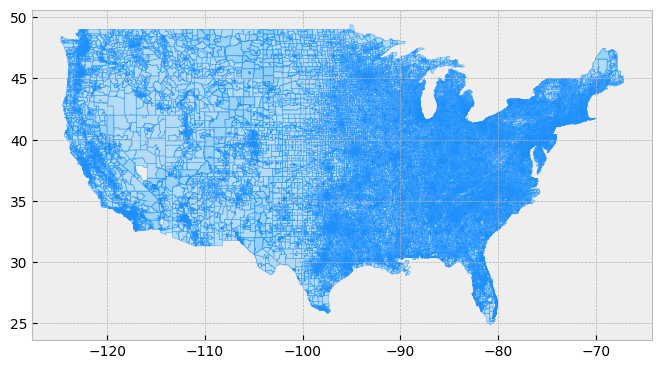

In [76]:
fig, ax = plt.subplots(1, 1, figsize = (8, 10))

# Plot data
df.plot(ax = ax, color = 'lightskyblue', edgecolor = 'dodgerblue', alpha = 0.55)

# Stylize plots
plt.style.use('bmh')

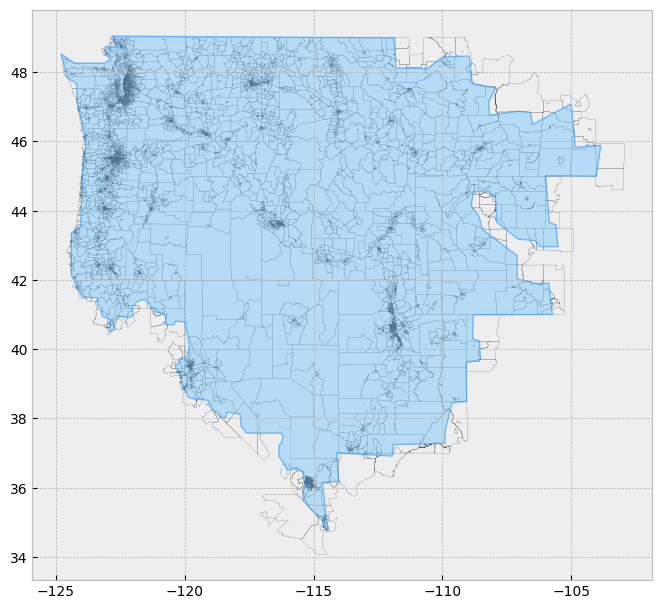

In [77]:
# Northern Grid and States

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 10))

nttg_gdf = df[df["REGIONS"] == "NorthernGrid"]

# nttg census blocks
nttg_raw = combined_gdf[combined_gdf.GEOID.isin(nttg_gdf.GEOID)]

# plot census blocks with slightly thin line
nttg_raw.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
rto_data[rto_data["REGIONS"] == "NorthernGrid"].plot(ax=ax, color='lightskyblue', edgecolor='dodgerblue', alpha=0.55, linewidth=1.0)

# Stylize plots
plt.style.use('bmh')

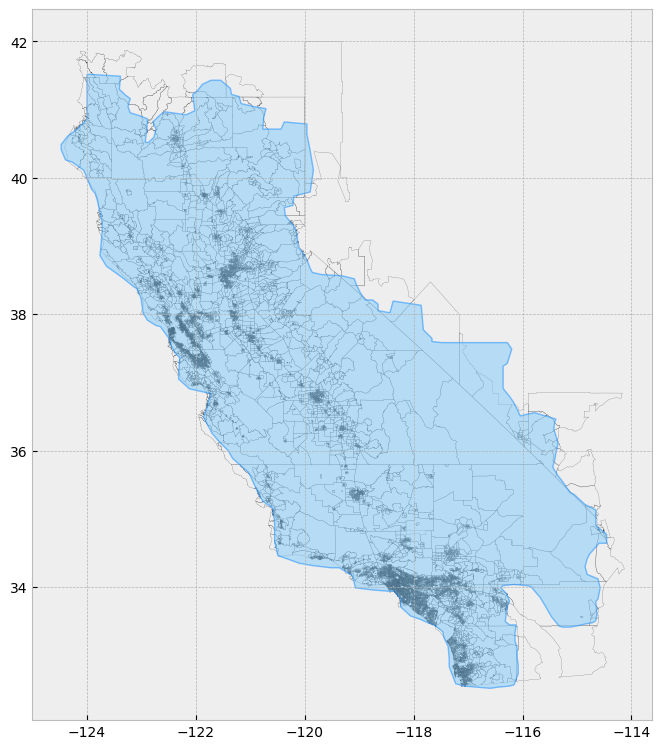

In [125]:
# CAISO and States

fig, ax = plt.subplots(1, 1, figsize = (8, 10))

caiso_gdf = df[df["REGIONS"] == "CAISO"]
# caiso_geometry_gdf = caiso_gdf.dissolve(by='REGIONS')

# caiso census blocks
caiso_raw = combined_gdf[combined_gdf.GEOID.isin(caiso_gdf.GEOID)]

# plot census blocks with slightly thin line
caiso_raw.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
rto_data[rto_data["REGIONS"] == "CAISO"].plot(ax=ax, color='lightskyblue', edgecolor='dodgerblue', alpha=0.55, linewidth=1.0)

# Stylize plots
plt.style.use('bmh')

In [84]:
nttg_gdf.POP20BG.astype(float).sum()

21549343.0

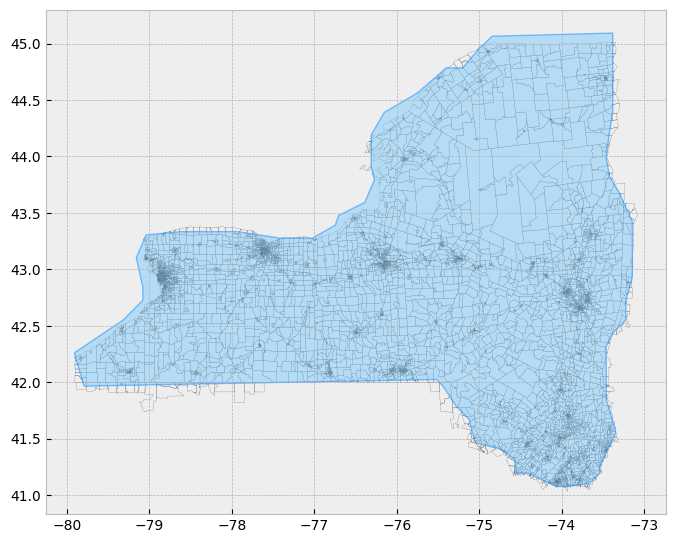

In [129]:
# NYISO and States

fig, ax = plt.subplots(1, 1, figsize = (8, 10))

nyiso_gdf = df[df["REGIONS"] == "NYISO"]

# nyisp census blocks
nyiso_raw = combined_gdf[combined_gdf.GEOID.isin(nyiso_gdf.GEOID)]

# plot census blocks with slightly thin line
nyiso_raw.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
rto_data[rto_data["REGIONS"] == "NYISO"].plot(ax=ax, color='lightskyblue', edgecolor='dodgerblue', alpha=0.55, linewidth=1.0)

# Stylize plots
plt.style.use('bmh')

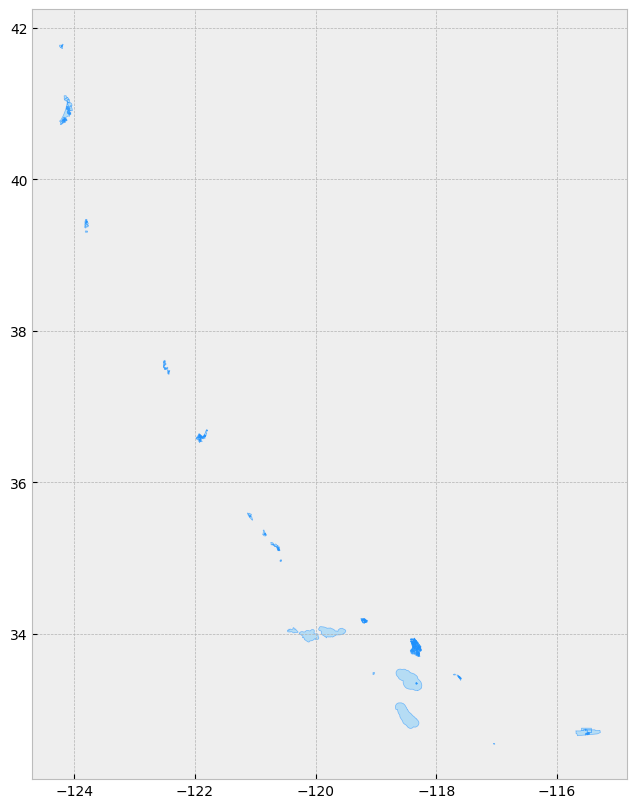

In [122]:
fig, ax = plt.subplots(1, 1, figsize = (8, 10))

# Plot data
ny.plot(ax = ax, color = 'lightskyblue', edgecolor = 'dodgerblue', alpha = 0.55)

# Stylize plots
plt.style.use('bmh')